# Libraries

In [ ]:
import pickle
import pandas as pd
import seaborn as sns
import os
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

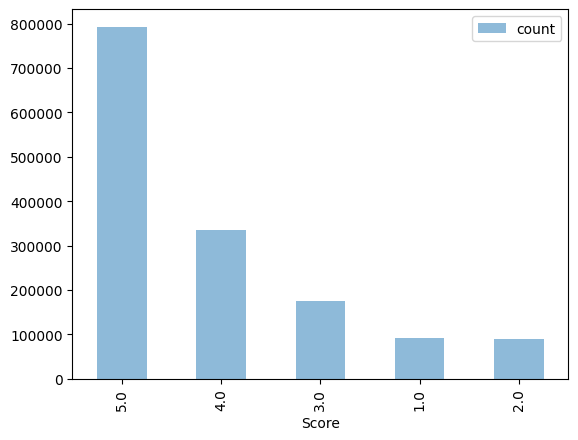


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [ ]:
trainingSet = pd.read_csv('/content/drive/MyDrive/train_final.csv')
testingSet = pd.read_csv('/content/drive/MyDrive/test_final.csv')


print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [ ]:
# Check and fill missing columns if necessary
for col in ['HelpfulnessNumerator', 'HelpfulnessDenominator']:
    if col not in trainingSet.columns:
        trainingSet[col] = 0  # Add column with default value
    if col not in testingSet.columns:
        testingSet[col] = 0  # Add column with default value

# Original feature extraction function with Helpfulness calculation
def add_features_to(df):
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    return df

# Apply the feature extraction function to both training and test sets
train = add_features_to(trainingSet)
test = add_features_to(testingSet)

# Function to add user review trends as additional features
def add_user_review_trends(df, reference_df):
    # Calculate user average score and negative review count from reference data
    user_avg_score = reference_df.groupby('Id')['Score'].mean().reset_index()
    user_avg_score.columns = ['Id', 'User_Avg_Score']

    user_negative_count = reference_df[reference_df['Score'] == 1].groupby('Id').size().reset_index(name='User_Negative_Count')

    # Merge these features into the main DataFrame
    df = df.merge(user_avg_score, on='Id', how='left')
    df = df.merge(user_negative_count, on='Id', how='left')

    # Handle NaN values for users not found in reference data
    df['User_Avg_Score'] = df['User_Avg_Score'].fillna(df['User_Avg_Score'].mean())
    df['User_Negative_Count'] = df['User_Negative_Count'].fillna(0)

    # Create a binary feature for multiple negative reviews
    df['Multiple_Negative_Reviews'] = (df['User_Negative_Count'] > 1).astype(int)

    return df

# Apply the new user trend features function to both train and test DataFrames
train = add_user_review_trends(train, train)
test = add_user_review_trends(test, train)  # Use training data as reference

# Merge on Id so that the submission set can have feature columns as well
X_submission = pd.merge(train, test, left_on='Id', right_on='Id', suffixes=('', '_test'))
X_submission = X_submission.drop(columns=['Score'])  # Drop duplicate Score after merge
X_submission = X_submission.rename(columns={'Score_test': 'Score'})

# Extract the training set where Score is not null
X_train = train[train['Score'].notnull()]

# Define paths and save processed data
X_train_path = "/content/drive/MyDrive/data/X_train.csv"
X_submission_path = "/content/drive/MyDrive/data/X_submission.csv"

os.makedirs('/content/drive/MyDrive/data', exist_ok=True)
X_train.to_csv(X_train_path, index=False)
X_submission.to_csv(X_submission_path, index=False)


# Sample + Split into training and testing set

In [ ]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Feature Selection

In [ ]:
features = [
    'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness',
    'User_Avg_Score', 'User_Negative_Count', 'Multiple_Negative_Reviews'
]
X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Model Creation

In [ ]:
# Learn the model
model = KNeighborsClassifier(n_neighbors=3).fit(X_train_select, Y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test_select)

# Model Evaluation

Accuracy on testing set = 0.8154824740935434


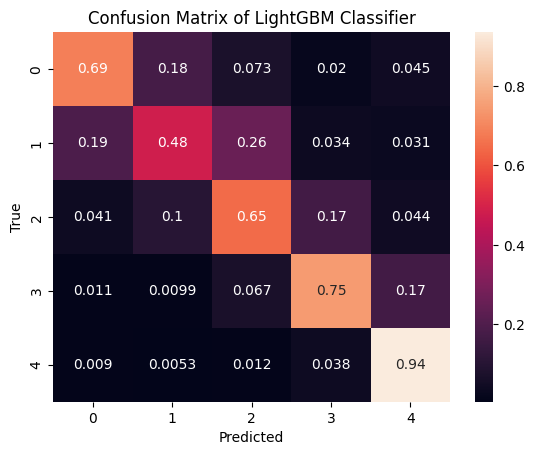

In [ ]:
# Model Evaluation for LightGBM
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate your model on the testing set
print("Accuracy on testing set =", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix of KNN Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Create submission file

In [ ]:
# Prepare the submission file with predictions on X_submission_select
Y_submission_predictions = model.predict(X_submission_select)

submission_df = pd.DataFrame({
    'Id': X_submission['Id'],
    'Score': Y_submission_predictions
})
submission_df.to_csv('/content/drive/MyDrive/data/submission.csv', index=False)
print("Submission file created at /content/drive/MyDrive/data/submission.csv")


Submission file created at /content/drive/MyDrive/data/submission.csv
